# Animal detection in the wild using Computer Vision and AI
**Task 4**. Computer vision: object detection, classification, segmentation, tracking

**Team Member**: Akom, Jerry

In [1]:
import os
import random
import shutil
from glob import glob
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support

import tensorflow as tf

## 1. Prepare Dataset

### 1.1. Set Folders

Data Source: [Animal Image Dataset (90 Different Animals)](https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals/data)

In [2]:
# Data dir
import kagglehub
input_data_soure = kagglehub.dataset_download(
    'iamsouravbanerjee/animal-image-dataset-90-different-animals'
)
os.listdir(input_data_soure)

['animals', 'name of the animals.txt']

In [3]:
# import kagglehub
input_dir = f'{input_data_soure}/animals/animals'
output_dir = './cis730_term_project/data'

train_dir = "./cis730_term_project/data/train"
val_dir = "./cis730_term_project/data/val"
test_dir = "./cis730_term_project/data/test"
checkpoint_dir = "./cis730_term_project/checkpoints"
results_dir = "./cis730_term_project/results"
image_dir = "./cis730_term_project/images"

for dir_path in [
    output_dir, train_dir, val_dir, test_dir,
    checkpoint_dir, results_dir, image_dir
]:
    os.makedirs(dir_path, exist_ok=True)

### 1.2. Vsualize Data Sample

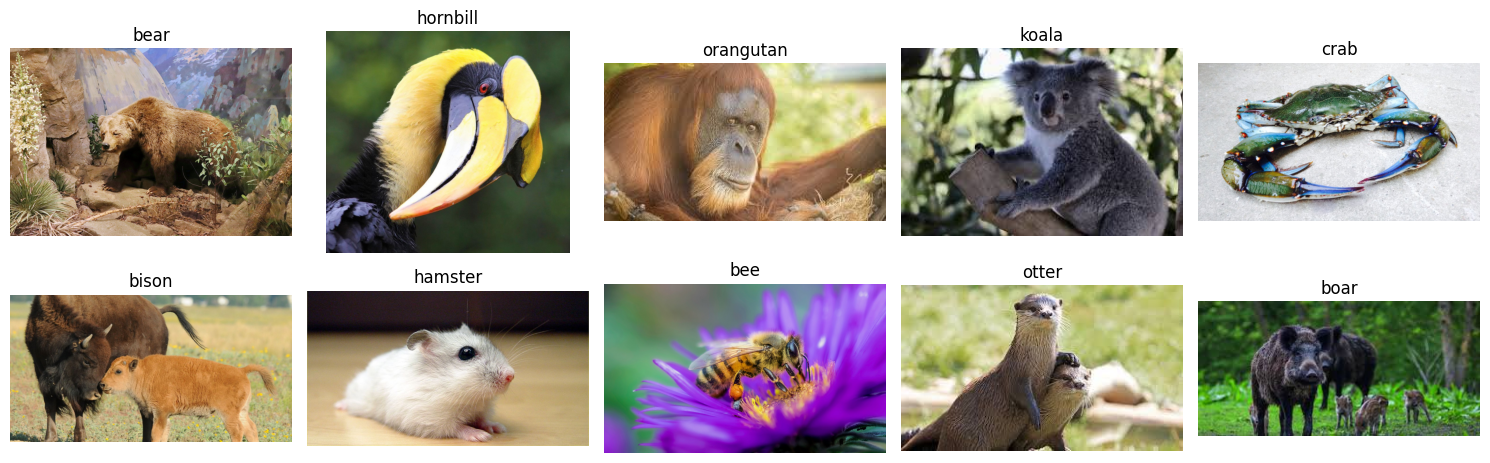

In [4]:
class_folders = [f for f in Path(input_dir).iterdir() if f.is_dir()]

sampled_classes = random.sample(class_folders, min(10, len(class_folders)))
plt.figure(figsize=(15, 5))

for idx, class_path in enumerate(sampled_classes):
    images = list(class_path.glob("*.jpg"))
    if not images:
        continue
    img_path = random.choice(images)
    img = Image.open(img_path)
    plt.subplot(2, 5, idx + 1)
    plt.imshow(img)
    plt.title(class_path.name)
    plt.axis("off")

plt.tight_layout()
plt.savefig(f"{image_dir}/data_sample.png")
plt.show()

### 1.3. Prepare Train / Validation / Test Sets

In [5]:
train_val_test_split = [0.7, 0.15, 0.15]

for class_path in class_folders:
    class_name = class_path.name
    images = list(class_path.glob("*.jpg"))
    if len(images) < 3:
        continue

    # First split into train and temp (val+test)
    train_imgs, temp_imgs = train_test_split(
        images, train_size=train_val_test_split[0], random_state=42
    )

    # Then split temp into val and test
    val_imgs, test_imgs = train_test_split(
        temp_imgs,
        train_size=train_val_test_split[1] / (train_val_test_split[1] + train_val_test_split[2]),
        random_state=42
    )

    # Now write to folders
    for subset_name, subset_imgs in zip(["train", "val", "test"], [train_imgs, val_imgs, test_imgs]):
        dest_class_dir = Path(output_dir) / subset_name / class_name
        for img_path in subset_imgs:
            try:
                dest_class_dir.mkdir(parents=True, exist_ok=True)
                dest_file_path = dest_class_dir / img_path.name
                shutil.copy(str(img_path), str(dest_file_path))
            except FileNotFoundError:
                print(f"File not found: {img_path}")
            except Exception as e:
                print(f"Error copying {img_path}: {e}")

## 2. Modelling (No Data Augmentation)

### 2.1. Modeling Functions

#### 2.1.1. Data Preparation Functions

In [6]:
# Image preparation function
def load_image_dataset(
    data_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical",
    shuffle=True,
    seed=123,
    model_name="mobilenet",
    augment=False
):
    if model_name == "mobilenet":
        if not augment:
            generator = tf.keras.preprocessing.image.ImageDataGenerator(
                preprocessing_function = tf.keras.applications.mobilenet.preprocess_input,
            )
        else:
            print(f'Performing data augmentations for {model_name} model')
            print()
            generator = tf.keras.preprocessing.image.ImageDataGenerator(
                preprocessing_function = tf.keras.applications.mobilenet.preprocess_input,
                rotation_range=20,
                width_shift_range=0.1,
                height_shift_range=0.1,
                zoom_range=0.1,
                horizontal_flip=True
            )

        data_tmp = generator.flow_from_directory(
            data_dir,
            target_size=image_size,
            batch_size=batch_size,
            class_mode=label_mode,
            shuffle=shuffle,
            seed=seed
        )

    elif model_name == "efficientnet":
        if not augment:
            generator = tf.keras.preprocessing.image.ImageDataGenerator(
                preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
            )
        else:
            print(f'Performing data augmentations for {model_name} model')
            print()
            generator = tf.keras.preprocessing.image.ImageDataGenerator(
                preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                rotation_range=20,
                width_shift_range=0.1,
                height_shift_range=0.1,
                zoom_range=0.1,
                horizontal_flip=True
            )

        data_tmp = generator.flow_from_directory(
            data_dir,
            target_size=image_size,
            batch_size=batch_size,
            class_mode=label_mode,
            shuffle=shuffle,
            seed=seed
        )

    elif model_name == "resnet":
        if not augment:
            generator = tf.keras.preprocessing.image.ImageDataGenerator(
                preprocessing_function = tf.keras.applications.resnet50.preprocess_input,
            )
        else:
            print(f'Performing data augmentations for {model_name} model')
            print()
            generator = tf.keras.preprocessing.image.ImageDataGenerator(
                preprocessing_function = tf.keras.applications.resnet50.preprocess_input,
                rotation_range=20,
                width_shift_range=0.1,
                height_shift_range=0.1,
                zoom_range=0.1,
                horizontal_flip=True
            )

        data_tmp = generator.flow_from_directory(
            data_dir,
            target_size=image_size,
            batch_size=batch_size,
            class_mode=label_mode,
            shuffle=shuffle,
            seed=seed
        )

    return data_tmp

#### 2.1.2. Model Build / Train functions

In [7]:
# Model Compile Parameters
compile_params = {
    'optimizer': 'adam',
    'loss': 'categorical_crossentropy',
    'metrics': ['accuracy']
}

# Build Models - 3 Models Considered: MobileNetV2, EfficientNetB3, ResNet50
def build_model(
    model_name="mobilenet",
    input_shape=(224, 224, 3),
    num_classes=10,
    compile_params=compile_params
):
    if model_name == "mobilenet":
        base_model = tf.keras.applications.MobileNetV2(
            input_shape=input_shape,
            include_top=False,
            weights="imagenet"
        )

    elif model_name == "efficientnet":
        base_model = tf.keras.applications.EfficientNetB3(
            input_shape=(300, 300, 3),
            include_top=False,
            weights="imagenet"
        )

    elif model_name == "resnet":
        base_model = tf.keras.applications.ResNet50(
            input_shape=input_shape,
            include_top=False,
            weights="imagenet"
        )

    else:
        raise ValueError("Choose one of: 'mobilenet', 'efficientnet', or 'resnet'")

    base_model.trainable = False  # Freeze base

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(
            num_classes,
            activation="softmax"
        )
    ])

    model.compile(**compile_params)

    return model

# Callbacks
def get_early_stopping_callback(
    monitor="val_loss",
    patience=3,
	restore_best_weights=True,
    verbose=1
):
    return tf.keras.callbacks.EarlyStopping(
        monitor=monitor,
        patience=patience,
        restore_best_weights=restore_best_weights,
        verbose=verbose,
    )

def get_check_point_callback(
	checkpoint_path="MobileNetV2CheckPoint.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
):
    return tf.keras.callbacks.ModelCheckpoint(
		checkpoint_path,
        monitor=monitor,
        save_best_only=save_best_only,
        verbose=verbose,
    )

# Predict on test data
def get_predictions(dataset, model):
    y_true = dataset.classes
    y_pred = np.argmax(model.predict(dataset), axis = 1)
    return y_true, y_pred

#### 2.1.3. Visualization functions

In [8]:
# To visualize training loss/accuracy
def plot_training_loss_accuracy(history, model_name="mobilenet", output_dir=image_dir):
    if model_name == "mobilenet":
        title_loss = "Loss MobileNetV2"
        title_acc = "Accuracy MobileNetV2"
    elif model_name == "efficientnet":
        title_loss = "Loss EfficientNetB3"
        title_acc = "Accuracy EfficientNetB0"
    elif model_name == "resnet":
        title_loss = "Loss ResNet50"
        title_acc = "Accuracy ResNet50"
    else:
        raise ValueError("Choose one of: 'mobilenet', 'efficientnet', or 'resnet'")

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(title_loss)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(title_acc)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.savefig(f"{output_dir}/{model_name}_accuracy_loss.png")
    plt.show()

def get_best_worst(y_true, y_pred, class_names):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate score
    precision, recall, f1, _ = \
        precision_recall_fscore_support(
            y_true,
            y_pred,
            labels=range(len(list(class_names)))
    )

    # Sort classes by F1 score
    sorted_indices = np.argsort(f1)
    worst_5 = sorted_indices[:5]
    best_5 = sorted_indices[-5:]


    print("Best 5 classes (F1 Score):")
    print([class_names[i] for i in best_5])
    print()
    print("Worst 5 classes (F1 Score):")
    print([class_names[i] for i in worst_5])

    return best_5, worst_5

def plot_confusion_for_classes(
    y_true, y_pred, selected_best, selected_worst, class_names, model_name,
    output_dir=image_dir
):
    # Filter the relevant rows and columns
    cm = confusion_matrix(y_true, y_pred)
    sub_cm_best = cm[np.ix_(selected_best, selected_best)]
    labels_best = [class_names[i] for i in selected_best]

    sub_cm_worst = cm[np.ix_(selected_worst, selected_worst)]
    labels_worst = [class_names[i] for i in selected_worst]

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Display confusion matrix 1
    disp1 = ConfusionMatrixDisplay(
        confusion_matrix=sub_cm_best, display_labels = labels_best
    )
    disp1.plot(ax=axes[0], colorbar=False)
    axes[0].set_title("Best 5 Predicted Classes (F1 Score)")
    axes[0].tick_params(axis='x', rotation=45)

    # Display confusion matrix 2
    disp2 = ConfusionMatrixDisplay(
        confusion_matrix=sub_cm_worst, display_labels = labels_worst
    )
    disp2.plot(ax=axes[1], colorbar=False)
    axes[1].set_title("Worst 5 Predicted Classes (F1 Score)")
    axes[1].tick_params(axis='x', rotation=45)

    fig.tight_layout()
    fig.savefig(
        f"{output_dir}/{model_name}_confusion_matrix.png", bbox_inches='tight'
    )
    plt.show()

def show_wrong_predictions(
    y_true, y_pred, wrong_indices, test_dir, model_name, num_images=10,
    output_dir=image_dir
):
    test_paths = list(Path(test_dir).rglob("*.jpg"))
    test_paths.sort()
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(wrong_indices[:num_images]):
        image_path = str(test_paths[idx])
        img = tf.keras.preprocessing.image.load_img(
            image_path, target_size=(224, 224)
        )
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.axis("off")
        pred_label = class_names[y_pred[idx]]
        true_label = class_names[y_true[idx]]
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color="red" if pred_label != true_label else "green")
    plt.suptitle("Wrong Predictions", fontsize=20)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{model_name}_wrong_predictiond.png")
    plt.show()

### 2.4. Model 1 - MobileNetV2
#### 2.4.0. Load Datasets

In [9]:
# Load datasets
train_mnv2 = load_image_dataset(train_dir)
val_mnv2 = load_image_dataset(val_dir)
test_mnv2 = load_image_dataset(test_dir, shuffle=False)

Found 3780 images belonging to 90 classes.
Found 810 images belonging to 90 classes.
Found 810 images belonging to 90 classes.


#### 2.4.1. Build / Train MobileNetV2 Model

Model Reference: [MobileNetV2](https://keras.io/api/applications/mobilenet/#mobilenetv2-function)

Source: https://storage.googleapis.com/tensorflow/keras-applications/mobilenet_v2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5

In [10]:
# Load model
model_mnv2 = build_model(
    "mobilenet",
    num_classes=train_mnv2.num_classes,
    compile_params=compile_params
)

# Train model
early_stop = get_early_stopping_callback()
model_check_point = get_check_point_callback(
    checkpoint_path=f"{checkpoint_dir}/MobileNetV2CheckPoint.keras"
)
history_mnv2 = model_mnv2.fit(
    train_mnv2,
    validation_data=val_mnv2,
    epochs=10,
    callbacks=[early_stop, model_check_point]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.3334 - loss: 3.1947
Epoch 1: val_loss improved from inf to 0.80063, saving model to ./cis730_term_project/checkpoints/MobileNetV2CheckPoint.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 48s 303ms/step - accuracy: 0.3353 - loss: 3.1853 - val_accuracy: 0.8160 - val_loss: 0.8006
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9114 - loss: 0.4832
Epoch 2: val_loss improved from 0.80063 to 0.58417, saving model to ./cis730_term_project/checkpoints/MobileNetV2CheckPoint.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 25s 214ms/step - accuracy: 0.9114 - loss: 0.4829 - val_accuracy: 0.8617 - val_loss: 0.5842
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9731 - loss: 0.2392
Epoch 3: val_loss improved from 0.58417 to 0.50797, saving model to ./cis730_term_project/checkpoints/MobileNetV2CheckPoint.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 26s 217ms/step - accuracy: 0.9731 - loss: 0.2392 - val_accuracy: 0.8605 - val_los

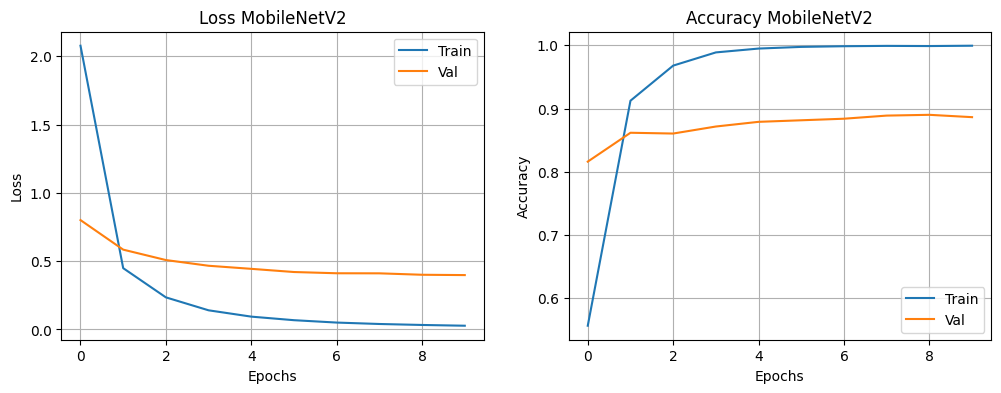

In [11]:
# Plot loss/accuracy
plot_training_loss_accuracy(history_mnv2)

#### 2.4.2. Fine Tune MobileNetV2 Model

In [12]:
model_mnv2.trainable = True
model_mnv2.summary(show_trainable=True)

model_mnv2.compile(**compile_params)

history_mnv2 = model_mnv2.fit(
    train_mnv2,
    validation_data=val_mnv2,
    epochs=10,
    callbacks=[early_stop, model_check_point]
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ mobilenetv2_1.00_224        │ (None, 7, 7, 1280)    │  2,257,984 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 90)            │    115,290 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 2,603,856 (9.93 MB)

 Trainable params: 115,290 (450.35 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 230,582 (900.71 KB)

Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9980 - loss: 0.0316
Epoch 1: val_loss did not improve from 0.39781
119/119 ━━━━━━━━━━━━━━━━━━━━ 38s 267ms/step - accuracy: 0.9980 - loss: 0.0316 - val_accuracy: 0.8864 - val_loss: 0.4187
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9997 - loss: 0.0136
Epoch 2: val_loss did not improve from 0.39781
119/119 ━━━━━━━━━━━━━━━━━━━━ 25s 214ms/step - accuracy: 0.9997 - loss: 0.0136 - val_accuracy: 0.8889 - val_loss: 0.4052
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9997 - loss: 0.0082
Epoch 3: val_loss did not improve from 0.39781
119/119 ━━━━━━━━━━━━━━━━━━━━ 25s 211ms/step - accuracy: 0.9997 - loss: 0.0082 - val_accuracy: 0.8938 - val_loss: 0.4105
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9999 - loss: 0.0061
Epoch 4: val_loss did not improve from 0.39781
119/119 ━━━━━━━━━━━━━━━━━━━━ 25s 209ms/step - accuracy: 0.9999 - loss: 0.0061 - val_accuracy: 0.8877

#### 2.4.3. Accuracy Report

##### Get Predictions

In [13]:
y_true_mnv2, y_pred_mnv2 = get_predictions(test_mnv2, model_mnv2)

26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 276ms/step


##### Classification Report

In [14]:
print(classification_report(y_true_mnv2, y_pred_mnv2, target_names=test_mnv2.class_indices.keys()))

                precision    recall  f1-score   support

      antelope       1.00      0.78      0.88         9
        badger       0.90      1.00      0.95         9
           bat       0.71      0.56      0.62         9
          bear       1.00      0.89      0.94         9
           bee       0.90      1.00      0.95         9
        beetle       1.00      0.89      0.94         9
         bison       1.00      1.00      1.00         9
          boar       1.00      1.00      1.00         9
     butterfly       0.90      1.00      0.95         9
           cat       0.90      1.00      0.95         9
   caterpillar       0.86      0.67      0.75         9
    chimpanzee       0.90      1.00      0.95         9
     cockroach       0.78      0.78      0.78         9
           cow       0.88      0.78      0.82         9
        coyote       0.73      0.89      0.80         9
          crab       1.00      1.00      1.00         9
          crow       0.80      0.89      0.84  

##### Best / Worst Predictions

In [15]:
class_names =  list(test_mnv2.class_indices.keys())

best_5_mnv2, worst_5_mnv2 = get_best_worst(
    y_true_mnv2, y_pred_mnv2, class_names
)

Best 5 classes (F1 Score):
['shark', 'sandpiper', 'turkey', 'swan', 'zebra']

Worst 5 classes (F1 Score):
['mouse', 'bat', 'rat', 'ox', 'squirrel']


##### Confusion Matrix

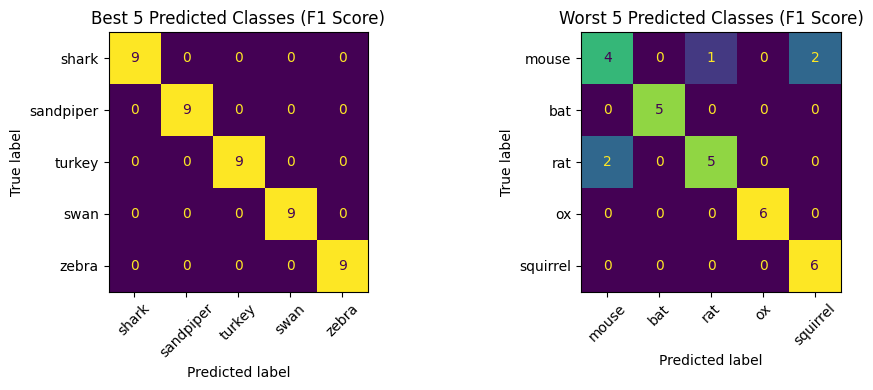

In [16]:
plot_confusion_for_classes(
    y_true_mnv2, y_pred_mnv2, best_5_mnv2, worst_5_mnv2,
    class_names, model_name = "mobilenet"
)

##### Wrong Predictions

Found 98 misclassified images.


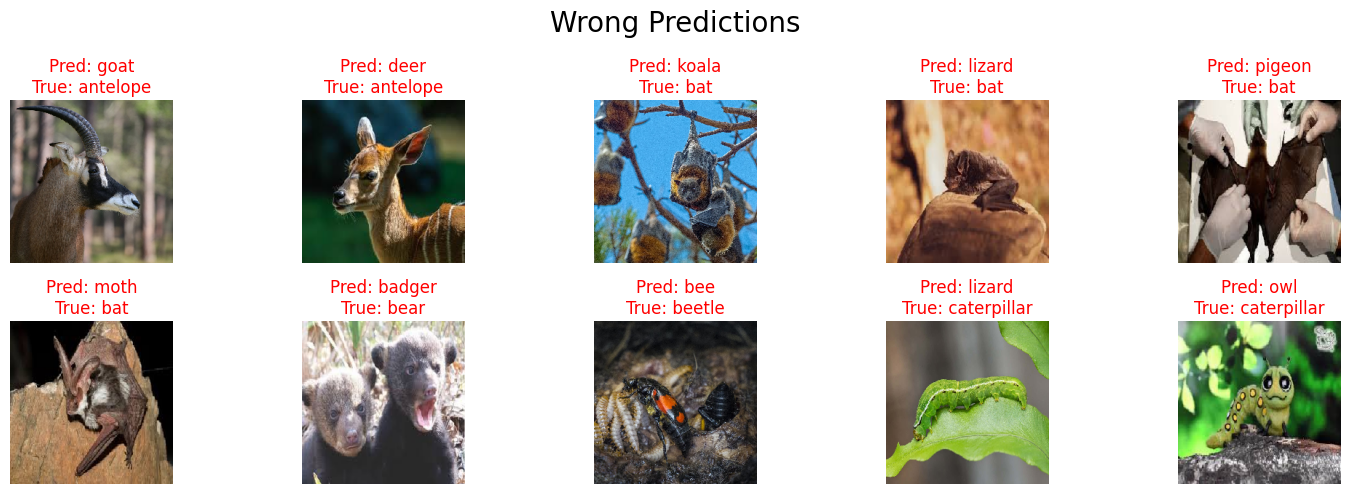

In [17]:
# Get wrong predictions
wrong_indices_mnv2 = np.where(y_true_mnv2 != y_pred_mnv2)[0]
print(f"Found {len(wrong_indices_mnv2)} misclassified images.")

# plot
show_wrong_predictions(y_true_mnv2, y_pred_mnv2, wrong_indices_mnv2, test_dir, model_name = "mobilenet")

##### Save Predictions

In [18]:
# Save Predictions
df_preds_mnv2 = pd.DataFrame({
    'filename': [str(os.path.basename(p)) for p in test_mnv2.filenames],
    'true_label': [class_names[i] for i in y_true_mnv2],
    'predicted_label': [class_names[i] for i in y_pred_mnv2],
    'correct': (y_true_mnv2 == y_pred_mnv2)
})

df_preds_mnv2.to_csv(f"{results_dir}/predictions_MobileNetV2.csv", index=False)

### 2.5. Model 2 - EfficientNetB3
#### 2.5.0. Load Datasets

In [19]:
# Load datasets
train_enB3 = load_image_dataset(train_dir, image_size=(300, 300), model_name = "efficientnet")
val_enB3 = load_image_dataset(val_dir, image_size=(300, 300), model_name = "efficientnet")
test_enB3 = load_image_dataset(test_dir, image_size=(300, 300), shuffle=False, model_name = "efficientnet")

Found 3780 images belonging to 90 classes.
Found 810 images belonging to 90 classes.
Found 810 images belonging to 90 classes.


#### 2.5.1. Build / Train EfficientNetB3 Model

Model Reference: [https://keras.io/api/applications/efficientnet/#efficientnetb3-function)

Source: https://storage.googleapis.com/keras-applications/efficientnetb3_notop.h5

In [20]:
compile_params.update(optimizer=tf.keras.optimizers.Adam(0.0005))

# Load model
model_enB3 = build_model(
    "efficientnet",
    num_classes=train_enB3.num_classes,
    compile_params=compile_params
)

early_stop = get_early_stopping_callback()
model_check_point = get_check_point_callback(
    checkpoint_path=f"{checkpoint_dir}/EfficientNetB3CheckPoint.keras"
)

# Train model
history_enB3 = model_enB3.fit(
    train_enB3,
    validation_data=val_enB3,
    epochs=10,
    callbacks=[early_stop, model_check_point]
)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.3454 - loss: 3.7448
Epoch 1: val_loss improved from inf to 1.63013, saving model to ./cis730_term_project/checkpoints/EfficientNetB3CheckPoint.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 105s 575ms/step - accuracy: 0.3475 - loss: 3.7384 - val_accuracy: 0.8654 - val_loss: 1.6301
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.8922 - loss: 1.2590
Epoch 2: val_loss improved from 1.63013 to 0.73234, saving model to ./cis730_term_project/checkpoints/EfficientNetB3CheckPoint.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 36s 303ms/step - accuracy: 0.8923 - loss: 1.2571 - val_accuracy: 0.9099 - val_loss: 0.7323
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9326 - loss: 0.5671
Epoch 3: val_loss improved from 0.73234 to 0.49366, saving model to ./cis730_term_project/checkpoints/EfficientNetB3CheckPoint.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 35s 297ms/step - accuracy: 0.9326 - loss: 0.5667 - val_accuracy: 0.9210

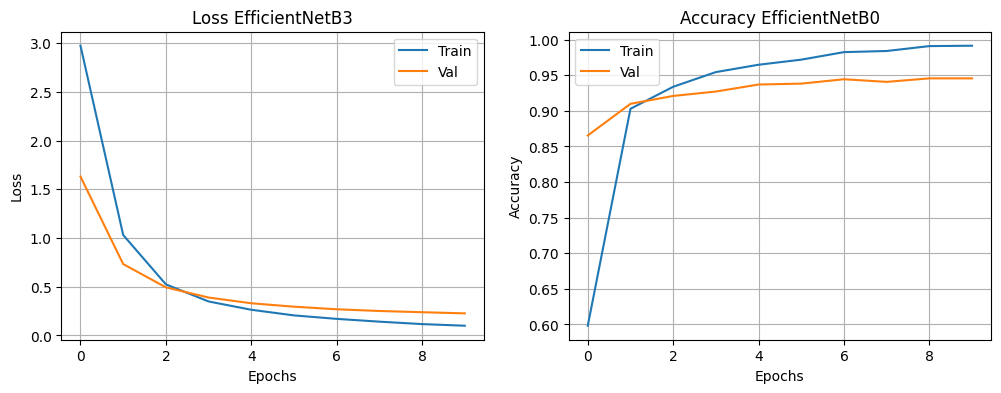

In [21]:
# Plot loss/accuracy
plot_training_loss_accuracy(history_enB3, model_name="efficientnet")

#### 2.5.2. Fine Tune EfficientNetB3 Model

In [22]:
model_enB3.trainable = True
model_enB3.summary(show_trainable=True)

model_enB3.compile(**compile_params)

history_enB3 = model_enB3.fit(
    train_enB3,
    validation_data=val_enB3,
    epochs=10,
    callbacks=[early_stop, model_check_point]
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ efficientnetb3 (Functional) │ (None, 10, 10, 1536)  │ 10,783,535 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_1  │ (None, 1536)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 90)            │    138,330 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 11,198,527 (42.72 MB)

 Trainable params: 138,330 (540.35 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

 Optimizer params: 276,662 (1.06 MB)

Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.9922 - loss: 0.0899
Epoch 1: val_loss improved from 0.22661 to 0.21912, saving model to ./cis730_term_project/checkpoints/EfficientNetB3CheckPoint.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 99s 573ms/step - accuracy: 0.9922 - loss: 0.0899 - val_accuracy: 0.9457 - val_loss: 0.2191
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9930 - loss: 0.0785
Epoch 2: val_loss improved from 0.21912 to 0.21307, saving model to ./cis730_term_project/checkpoints/EfficientNetB3CheckPoint.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 35s 293ms/step - accuracy: 0.9930 - loss: 0.0785 - val_accuracy: 0.9420 - val_loss: 0.2131
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9957 - loss: 0.0682
Epoch 3: val_loss improved from 0.21307 to 0.20707, saving model to ./cis730_term_project/checkpoints/EfficientNetB3CheckPoint.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 39s 329ms/step - accuracy: 0.9957 - loss: 0.0682 - val_accuracy: 0.9

#### 2.5.3. Accuracy Report
##### Get Predictions

In [23]:
# Get Predictions
y_true_enB3, y_pred_enB3 = get_predictions(test_enB3, model_enB3)

26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 587ms/step


##### Classification Report

In [24]:
print(classification_report(
    y_true_enB3, y_pred_enB3, target_names=test_enB3.class_indices.keys()
))

                precision    recall  f1-score   support

      antelope       1.00      0.89      0.94         9
        badger       1.00      1.00      1.00         9
           bat       0.88      0.78      0.82         9
          bear       1.00      1.00      1.00         9
           bee       1.00      1.00      1.00         9
        beetle       1.00      0.89      0.94         9
         bison       1.00      1.00      1.00         9
          boar       1.00      1.00      1.00         9
     butterfly       0.82      1.00      0.90         9
           cat       0.82      1.00      0.90         9
   caterpillar       1.00      0.78      0.88         9
    chimpanzee       1.00      1.00      1.00         9
     cockroach       1.00      1.00      1.00         9
           cow       1.00      0.78      0.88         9
        coyote       0.89      0.89      0.89         9
          crab       1.00      1.00      1.00         9
          crow       1.00      1.00      1.00  

##### Best / Worst Predictions

In [25]:
class_names =  list(test_enB3.class_indices.keys())

best_5_enB3, worst_5_enB3 = get_best_worst(
    y_true_enB3, y_pred_enB3, class_names
)

Best 5 classes (F1 Score):
['turtle', 'whale', 'wombat', 'woodpecker', 'zebra']

Worst 5 classes (F1 Score):
['mouse', 'rat', 'goat', 'octopus', 'squirrel']


##### Confusion Matrix

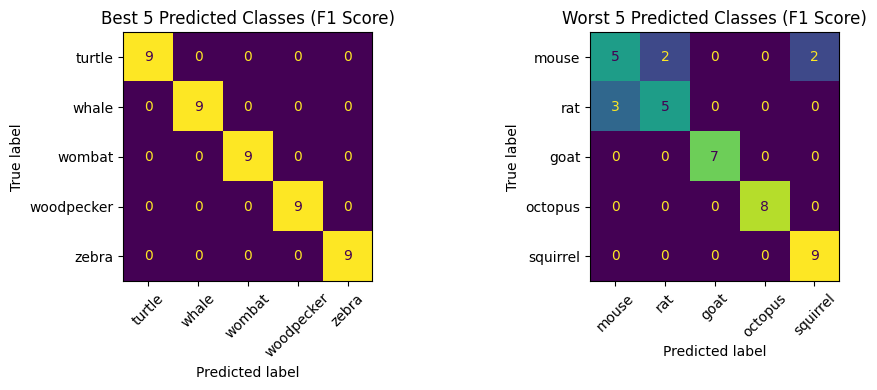

In [26]:
plot_confusion_for_classes(
    y_true_enB3, y_pred_enB3, best_5_enB3, worst_5_enB3,
    class_names, model_name = "efficientnet"
)

##### Wrong Predictions

Found 40 misclassified images.


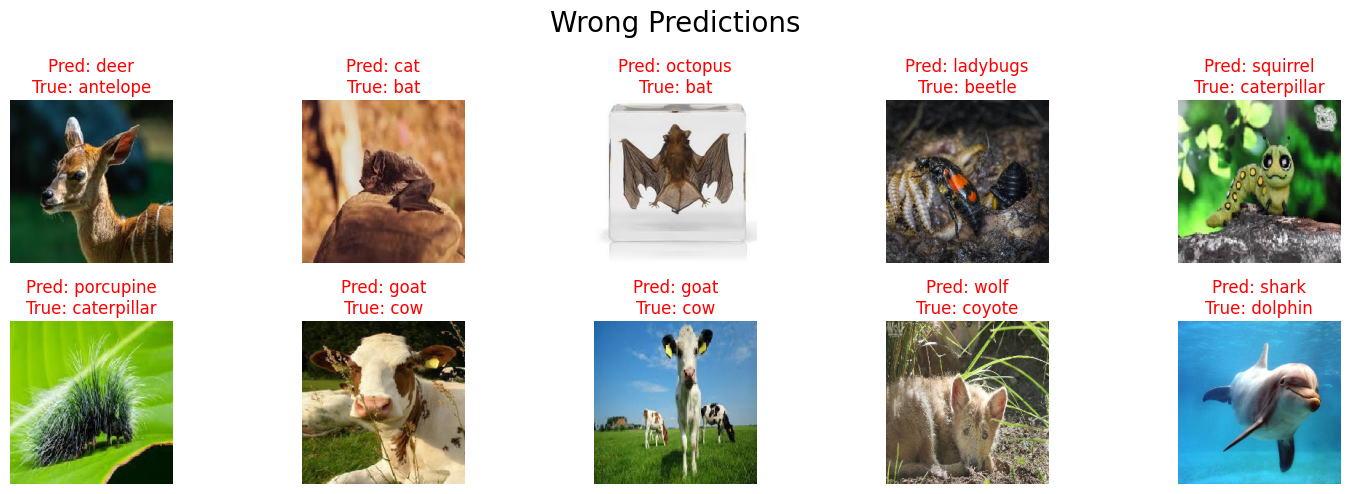

In [27]:
# Get wrong predictions
wrong_indices_enB3 = np.where(y_true_enB3 != y_pred_enB3)[0]
print(f"Found {len(wrong_indices_enB3)} misclassified images.")

# plot
show_wrong_predictions(
    y_true_enB3, y_pred_enB3, wrong_indices_enB3,
    test_dir, model_name = "efficientnet"
)

##### Save Predictions

In [28]:
# Save Predictions
df_preds_enB3 = pd.DataFrame({
    'filename': [str(os.path.basename(p)) for p in test_enB3.filenames],
    'true_label': [class_names[i] for i in y_true_enB3],
    'predicted_label': [class_names[i] for i in y_pred_enB3],
    'correct': (y_true_enB3 == y_pred_enB3)
})

df_preds_enB3.to_csv(f"{results_dir}/predictions_EfficientNetB3.csv", index=False)

In [29]:
train_dir

'./cis730_term_project/data/train'

### 2.6. Model 3 - ResNet50
#### 2.6.0. Load Datasets

In [30]:
# Load datasets
train_rn50 = load_image_dataset(train_dir, model_name ="resnet")
val_rn50 = load_image_dataset(val_dir, model_name = "resnet")
test_rn50 = load_image_dataset(test_dir, shuffle=False, model_name = "resnet")

Found 3780 images belonging to 90 classes.
Found 810 images belonging to 90 classes.
Found 810 images belonging to 90 classes.


#### 2.6.1. Build / Train ResNet50 Model

Model Reference: [https://keras.io/api/applications/resnet/#resnet50-function)

Source: https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5  

In [31]:
compile_params.update(optimizer=tf.keras.optimizers.Adam(0.0005))

# Load model
model_rn50 = build_model(
    "resnet",
    num_classes=train_rn50.num_classes,
    compile_params=compile_params
)

early_stop_rn50 = get_early_stopping_callback()
model_check_point_rn50 = get_check_point_callback(
    checkpoint_path=f"{checkpoint_dir}/ResNet50CheckPoint.keras"
)

# Train model
history_rn50 = model_rn50.fit(
    train_rn50,
    validation_data=val_rn50,
    epochs=10,
    callbacks=[early_stop_rn50, model_check_point_rn50]
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.2252 - loss: 3.6815
Epoch 1: val_loss improved from inf to 1.17967, saving model to ./cis730_term_project/checkpoints/ResNet50CheckPoint.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 53s 344ms/step - accuracy: 0.2269 - loss: 3.6725 - val_accuracy: 0.7481 - val_loss: 1.1797
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.8646 - loss: 0.7711
Epoch 2: val_loss improved from 1.17967 to 0.72392, saving model to ./cis730_term_project/checkpoints/ResNet50CheckPoint.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 66s 250ms/step - accuracy: 0.8647 - loss: 0.7703 - val_accuracy: 0.8395 - val_loss: 0.7239
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9500 - loss: 0.3734
Epoch 3: val_loss improved from 0.72392 to 0.57050, saving model to ./cis730_term_project/checkpoints/ResNet50CheckPoint.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 31s 256ms/step - accuracy: 0.9500 - loss: 0.3732 - val_accuracy: 0.8753 - val_loss: 0.5705

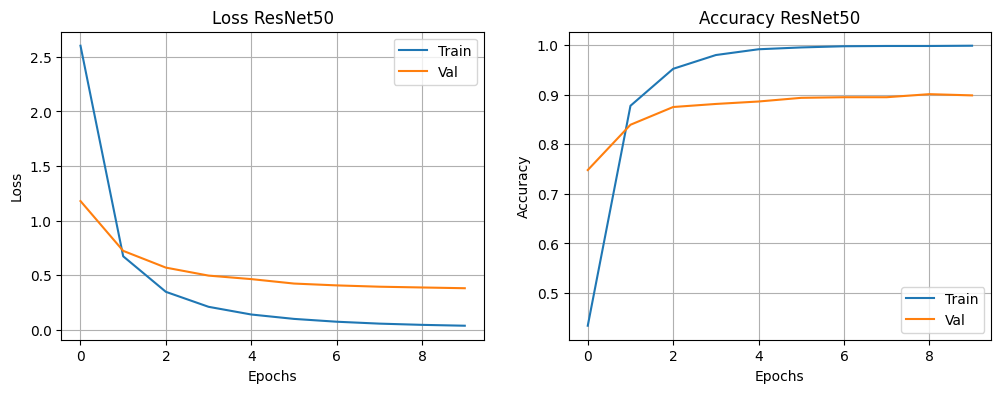

In [32]:
# Plot loss/accuracy
plot_training_loss_accuracy(history_rn50, model_name="resnet")

#### 2.6.2. Fine Tune ResNet50 Model

In [33]:
model_rn50.trainable = True
model_rn50.summary(show_trainable=True)

model_rn50.compile(**compile_params)

history_rn50 = model_rn50.fit(
    train_rn50,
    validation_data=val_rn50,
    epochs=10,
    callbacks=[early_stop, model_check_point]
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ resnet50 (Functional)       │ (None, 7, 7, 2048)    │ 23,587,712 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_2  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 90)            │    184,410 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 24,140,944 (92.09 MB)

 Trainable params: 184,410 (720.35 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 368,822 (1.41 MB)

Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9993 - loss: 0.0331
Epoch 1: val_loss did not improve from 0.18304
119/119 ━━━━━━━━━━━━━━━━━━━━ 47s 313ms/step - accuracy: 0.9993 - loss: 0.0331 - val_accuracy: 0.9037 - val_loss: 0.3729
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 1.0000 - loss: 0.0281
Epoch 2: val_loss did not improve from 0.18304
119/119 ━━━━━━━━━━━━━━━━━━━━ 29s 242ms/step - accuracy: 0.9999 - loss: 0.0281 - val_accuracy: 0.8988 - val_loss: 0.3643
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.9998 - loss: 0.0233
Epoch 3: val_loss did not improve from 0.18304
119/119 ━━━━━━━━━━━━━━━━━━━━ 34s 282ms/step - accuracy: 0.9998 - loss: 0.0233 - val_accuracy: 0.8938 - val_loss: 0.3638
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9999 - loss: 0.0206
Epoch 4: val_loss did not improve from 0.18304
119/119 ━━━━━━━━━━━━━━━━━━━━ 28s 238ms/step - accuracy: 0.9999 - loss: 0.0206 - val_accuracy: 0.8988

#### 2.6.3. Accuracy Report
##### Get Predictions

In [34]:
# Get Predictions
y_true_rn50, y_pred_rn50 = get_predictions(test_rn50, model_rn50)

26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 327ms/step


##### Classification Report

In [35]:
print(classification_report(
    y_true_rn50, y_pred_rn50, target_names=test_rn50.class_indices.keys()
))

                precision    recall  f1-score   support

      antelope       0.73      0.89      0.80         9
        badger       1.00      1.00      1.00         9
           bat       0.75      0.67      0.71         9
          bear       1.00      1.00      1.00         9
           bee       0.90      1.00      0.95         9
        beetle       1.00      1.00      1.00         9
         bison       0.90      1.00      0.95         9
          boar       0.82      1.00      0.90         9
     butterfly       1.00      1.00      1.00         9
           cat       0.90      1.00      0.95         9
   caterpillar       0.73      0.89      0.80         9
    chimpanzee       1.00      1.00      1.00         9
     cockroach       1.00      1.00      1.00         9
           cow       1.00      1.00      1.00         9
        coyote       0.90      1.00      0.95         9
          crab       1.00      0.89      0.94         9
          crow       0.82      1.00      0.90  

##### Best / Worst Predictions

In [36]:
class_names =  list(test_rn50.class_indices.keys())

best_5_rn50, worst_5_rn50 = get_best_worst(
    y_true_rn50, y_pred_rn50, class_names
)

Best 5 classes (F1 Score):
['shark', 'pigeon', 'turkey', 'swan', 'zebra']

Worst 5 classes (F1 Score):
['mouse', 'bat', 'owl', 'moth', 'rat']


##### Confusion Matrix

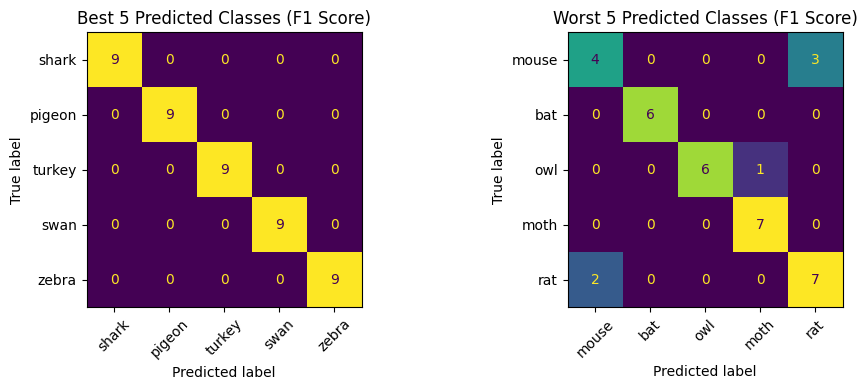

In [37]:
plot_confusion_for_classes(
    y_true_rn50, y_pred_rn50, best_5_rn50, worst_5_rn50,
    class_names, model_name = "resnet"
)

##### Wrong Predictions

Found 79 misclassified images.


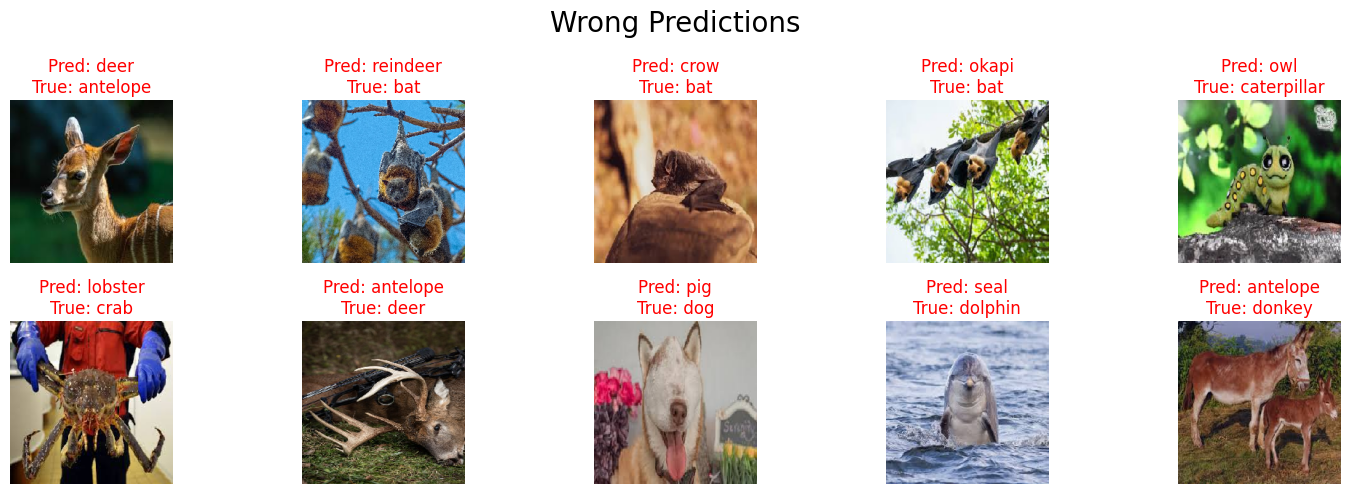

In [38]:
# Get wrong predictions
wrong_indices_rn50 = np.where(y_true_rn50 != y_pred_rn50)[0]
print(f"Found {len(wrong_indices_rn50)} misclassified images.")

# plot
show_wrong_predictions(
    y_true_rn50, y_pred_rn50, wrong_indices_rn50,
    test_dir, model_name = "resnet"
)

##### Save Predictions

In [39]:
# Save Predictions
df_preds_rn50 = pd.DataFrame({
    'filename': [str(os.path.basename(p)) for p in test_rn50.filenames],
    'true_label': [class_names[i] for i in y_true_rn50],
    'predicted_label': [class_names[i] for i in y_pred_rn50],
    'correct': (y_true_rn50 == y_pred_rn50)
})

df_preds_rn50.to_csv(f"{results_dir}/predictions_ResNet50.csv", index=False)

## 3. Modelling with Data Augmentations

### 3.0. Function to run all 3 models with augmentation

In [40]:
image_dir_aug = "./cis730_term_project/images/data_augmented"
os.makedirs(image_dir_aug, exist_ok=True)

def run_augmentation_processes(
        train_dir=train_dir,
        val_dir=val_dir,
        test_dir=test_dir,
        model_name="mobilenet",
        keras_model="MobileNetV2",
        index=0,
        compile_params=compile_params
    ):

    print(f'=================================================')
    print()
    print(f'3.{index+1}. MODEL 1 - {keras_model}')
    print()
    print(f'=================================================')
    print()

    # Load datasets
    print(f'3.{index+1}.0. LOAD DATASETS \n PERFORM IMAGE AUGMENTATIONS ON TRAINING SET.**')
    print()
    if model_name == "efficientnet":
        train_ds = load_image_dataset(
            train_dir, image_size=(300, 300), model_name=model_name, augment=True
        )
        val_ds = load_image_dataset(val_dir, image_size=(300, 300), model_name=model_name)
        test_ds = load_image_dataset(
            test_dir, image_size=(300, 300), model_name=model_name, shuffle=False
            )
    else:
        train_ds = load_image_dataset(train_dir, model_name=model_name, augment=True)
        val_ds = load_image_dataset(val_dir, model_name=model_name)
        test_ds = load_image_dataset(test_dir, model_name=model_name, shuffle=False)
    print()
    print("-------------------------------------------------")
    print()

    # Train model
    print(f'3.{index+1}.1. BUILD / TRAIN {keras_model} MODEL.')
    print()
    compile_params.update(optimizer=tf.keras.optimizers.Adam(0.0005))

    model = build_model(
        model_name,
        num_classes=train_ds.num_classes,
        compile_params=compile_params
    )

    early_stop = get_early_stopping_callback()
    model_check_point = get_check_point_callback(
        checkpoint_path=f"{checkpoint_dir}/{keras_model}CheckPoint_data_augment.keras"
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        callbacks=[early_stop, model_check_point]
    )
    print()
    print("-------------------------------------------------")
    print()

    # Plot loss/accuracy
    print(f'**Training loss/accuracy for {keras_model} model.')
    print()
    plot_training_loss_accuracy(
        history, model_name=model_name, output_dir=image_dir_aug
    )
    print()
    print("-------------------------------------------------")
    print()

    # Fine Tune
    print(f'3.{index+1}.2. FINE TUNE {keras_model} MODEL.')
    print()
    model.trainable = True
    model.summary(show_trainable=True)
    print()
    print("-------------------------------------------------")
    print()

    model.compile(**compile_params)

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        callbacks=[early_stop, model_check_point]
    )
    print()
    print("-------------------------------------------------")
    print()

    print(f'3.{index+1}.3. for {keras_model}.**')
    print()
    # Get Predictions
    print(f'**Get Predictions for {keras_model}.**')
    print()
    y_true, y_pred = get_predictions(test_ds, model)

    # Classification
    print(f'**Classification Report for {keras_model}.**')
    print()
    print(classification_report(
        y_true, y_pred, target_names=test_ds.class_indices.keys()
    ))
    print()
    print("-------------------------------------------------")
    print()

    # Get Best and Worst
    print(f'**Best and Worst for {keras_model}.**')
    print()
    class_names =  list(test_ds.class_indices.keys())

    best_5, worst_5 = get_best_worst(
        y_true, y_pred, class_names
    )
    print()
    print("-------------------------------------------------")
    print()

    # Confusion
    print(f'**Confusion Matrix for {keras_model}.**')
    print()
    plot_confusion_for_classes(
        y_true, y_pred, best_5, worst_5, class_names, model_name=model_name,
        output_dir=image_dir_aug
    )
    print()
    print("-------------------------------------------------")
    print()

    print(f'**Wrong predictions for {keras_model}.**')
    print()
    # Get wrong predictions
    wrong_indices = np.where(y_true != y_pred)[0]
    print(f"Found {len(wrong_indices)} misclassified images.")
    print()
    print("-------------------------------------------------")
    print()

    # Show some wrong predictions
    show_wrong_predictions(
        y_true, y_pred, wrong_indices, test_dir, model_name=model_name,
        output_dir=image_dir_aug
    )
    print()
    print("-------------------------------------------------")
    print()

    # Save Predictions
    print(f'**Save Predictions for {keras_model}.**')
    print()
    df_preds = pd.DataFrame({
        'filename': [str(os.path.basename(p)) for p in test_ds.filenames],
        'true_label': [class_names[i] for i in y_true],
        'predicted_label': [class_names[i] for i in y_pred],
        'correct': (y_true == y_pred)
    })

    df_preds.to_csv(f"{results_dir}/predictions_{keras_model}_data_augment.csv", index=False)
    print()
    print("-------------------------------------------------")
    print("-------------------------------------------------")
    print()
    print()
    print()
    print()

### Run with augmented data

1 mobilenet MobileNetV2

3.1. MODEL 1 - MobileNetV2


3.1.0. LOAD DATASETS 
 PERFORM IMAGE AUGMENTATIONS ON TRAINING SET.**

Performing data augmentations for mobilenet model

Found 3780 images belonging to 90 classes.
Found 810 images belonging to 90 classes.
Found 810 images belonging to 90 classes.

-------------------------------------------------

3.1.1. BUILD / TRAIN MobileNetV2 MODEL.



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.1706 - loss: 3.9466
Epoch 1: val_loss improved from inf to 1.60564, saving model to ./cis730_term_project/checkpoints/MobileNetV2CheckPoint_data_augment.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 75s 576ms/step - accuracy: 0.1722 - loss: 3.9392 - val_accuracy: 0.7383 - val_loss: 1.6056
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.7799 - loss: 1.3108
Epoch 2: val_loss improved from 1.60564 to 0.89785, saving model to ./cis730_term_project/checkpoints/MobileNetV2CheckPoint_data_augment.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 62s 517ms/step - accuracy: 0.7800 - loss: 1.3094 - val_accuracy: 0.8383 - val_loss: 0.8978
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.8615 - loss: 0.7234
Epoch 3: val_loss improved from 0.89785 to 0.69580, saving model to ./cis730_term_project/checkpoints/MobileNetV2CheckPoint_data_augment.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 62s 520ms/step - accuracy: 0.8615 - loss: 

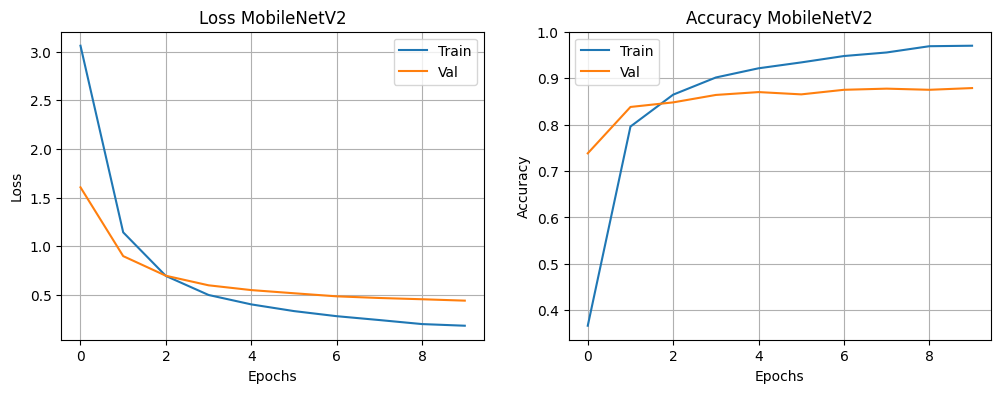


-------------------------------------------------

3.1.2. FINE TUNE MobileNetV2 MODEL.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ mobilenetv2_1.00_224        │ (None, 7, 7, 1280)    │  2,257,984 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_3  │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 90)            │    115,290 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 2,603,856 (9.93 MB)

 Trainable params: 115,290 (450.35 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 230,582 (900.71 KB)


-------------------------------------------------

Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.9704 - loss: 0.1719
Epoch 1: val_loss did not improve from 0.43980
119/119 ━━━━━━━━━━━━━━━━━━━━ 74s 568ms/step - accuracy: 0.9704 - loss: 0.1719 - val_accuracy: 0.8790 - val_loss: 0.4441
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.9782 - loss: 0.1383
Epoch 2: val_loss improved from 0.43980 to 0.42920, saving model to ./cis730_term_project/checkpoints/MobileNetV2CheckPoint_data_augment.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 61s 516ms/step - accuracy: 0.9782 - loss: 0.1383 - val_accuracy: 0.8889 - val_loss: 0.4292
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.9865 - loss: 0.1260
Epoch 3: val_loss did not improve from 0.42920
119/119 ━━━━━━━━━━━━━━━━━━━━ 81s 509ms/step - accuracy: 0.9865 - loss: 0.1260 - val_accuracy: 0.8815 - val_loss: 0.4308
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.9849 - loss: 0.1240

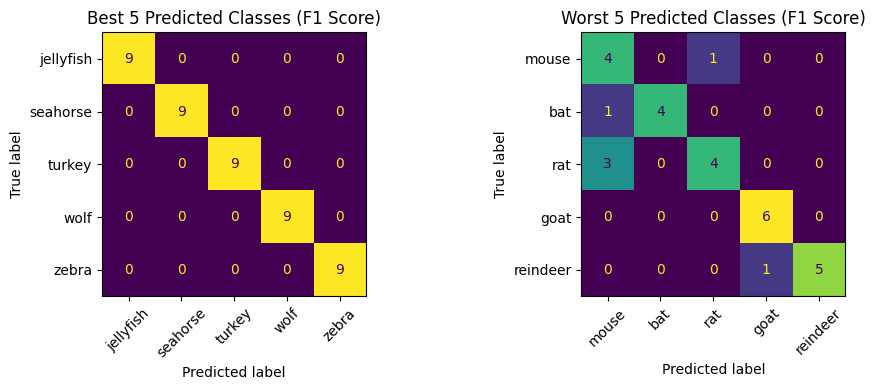


-------------------------------------------------

**Wrong predictions for MobileNetV2.**

Found 96 misclassified images.

-------------------------------------------------



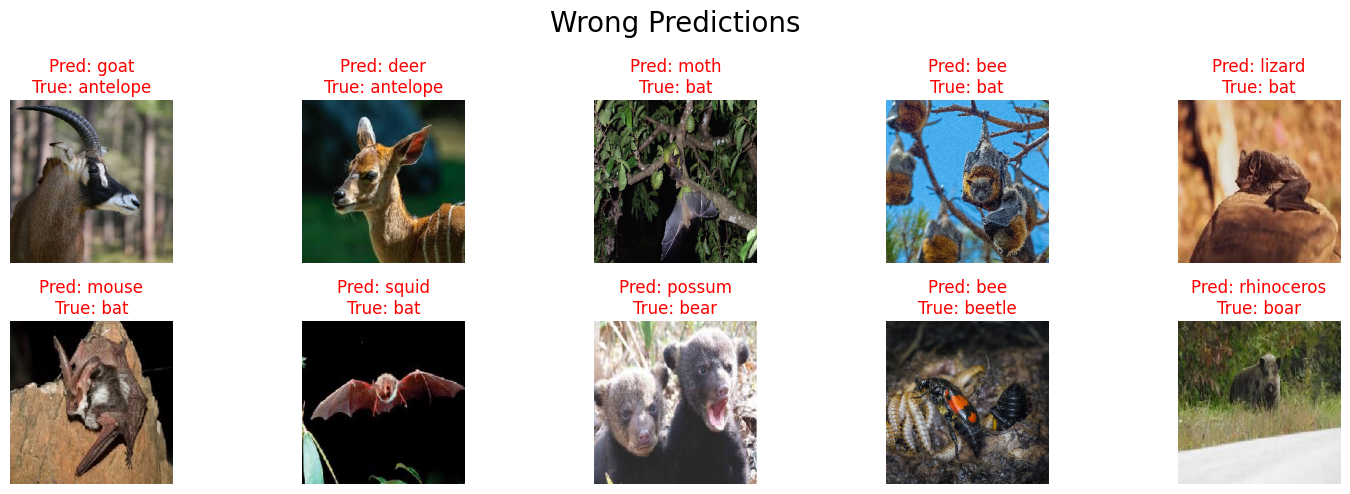


-------------------------------------------------

**Save Predictions for MobileNetV2.**


-------------------------------------------------
-------------------------------------------------




2 efficientnet EfficientNetB3

3.2. MODEL 1 - EfficientNetB3


3.2.0. LOAD DATASETS 
 PERFORM IMAGE AUGMENTATIONS ON TRAINING SET.**

Performing data augmentations for efficientnet model

Found 3780 images belonging to 90 classes.
Found 810 images belonging to 90 classes.
Found 810 images belonging to 90 classes.

-------------------------------------------------

3.2.1. BUILD / TRAIN EfficientNetB3 MODEL.



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.3325 - loss: 3.7669
Epoch 1: val_loss improved from inf to 1.71610, saving model to ./cis730_term_project/checkpoints/EfficientNetB3CheckPoint_data_augment.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.3345 - loss: 3.7607 - val_accuracy: 0.8568 - val_loss: 1.7161
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 787ms/step - accuracy: 0.8790 - loss: 1.3074
Epoch 2: val_loss improved from 1.71610 to 0.78300, saving model to ./cis730_term_project/checkpoints/EfficientNetB3CheckPoint_data_augment.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 158s 852ms/step - accuracy: 0.8791 - loss: 1.3056 - val_accuracy: 0.9086 - val_loss: 0.7830
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - accuracy: 0.9263 - loss: 0.6198
Epoch 3: val_loss improved from 0.78300 to 0.52616, saving model to ./cis730_term_project/checkpoints/EfficientNetB3CheckPoint_data_augment.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 142s 846ms/step - accuracy: 0.9263

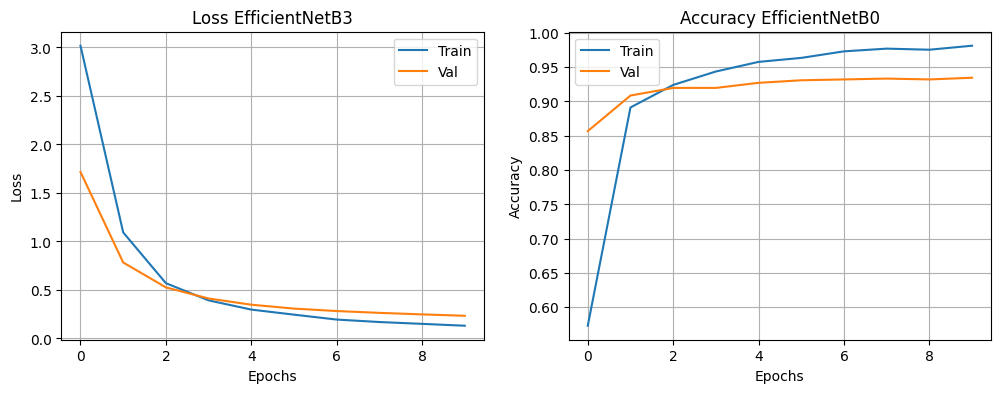


-------------------------------------------------

3.2.2. FINE TUNE EfficientNetB3 MODEL.



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ efficientnetb3 (Functional) │ (None, 10, 10, 1536)  │ 10,783,535 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_4  │ (None, 1536)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_4 (Dense)             │ (None, 90)            │    138,330 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 11,198,527 (42.72 MB)

 Trainable params: 138,330 (540.35 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

 Optimizer params: 276,662 (1.06 MB)


-------------------------------------------------

Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - accuracy: 0.9839 - loss: 0.1191
Epoch 1: val_loss improved from 0.23330 to 0.22639, saving model to ./cis730_term_project/checkpoints/EfficientNetB3CheckPoint_data_augment.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.9839 - loss: 0.1191 - val_accuracy: 0.9383 - val_loss: 0.2264
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.9872 - loss: 0.0980
Epoch 2: val_loss improved from 0.22639 to 0.21825, saving model to ./cis730_term_project/checkpoints/EfficientNetB3CheckPoint_data_augment.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 162s 877ms/step - accuracy: 0.9872 - loss: 0.0980 - val_accuracy: 0.9370 - val_loss: 0.2182
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - accuracy: 0.9926 - loss: 0.0872
Epoch 3: val_loss improved from 0.21825 to 0.20871, saving model to ./cis730_term_project/checkpoints/EfficientNetB3CheckPoint_data_augment.keras
119/119

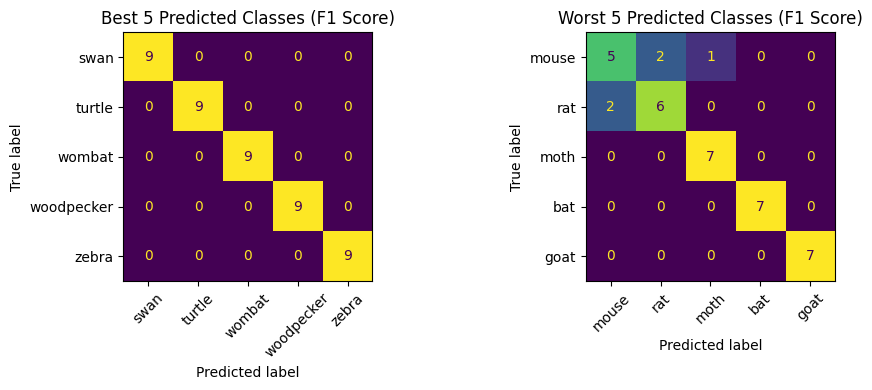


-------------------------------------------------

**Wrong predictions for EfficientNetB3.**

Found 41 misclassified images.

-------------------------------------------------



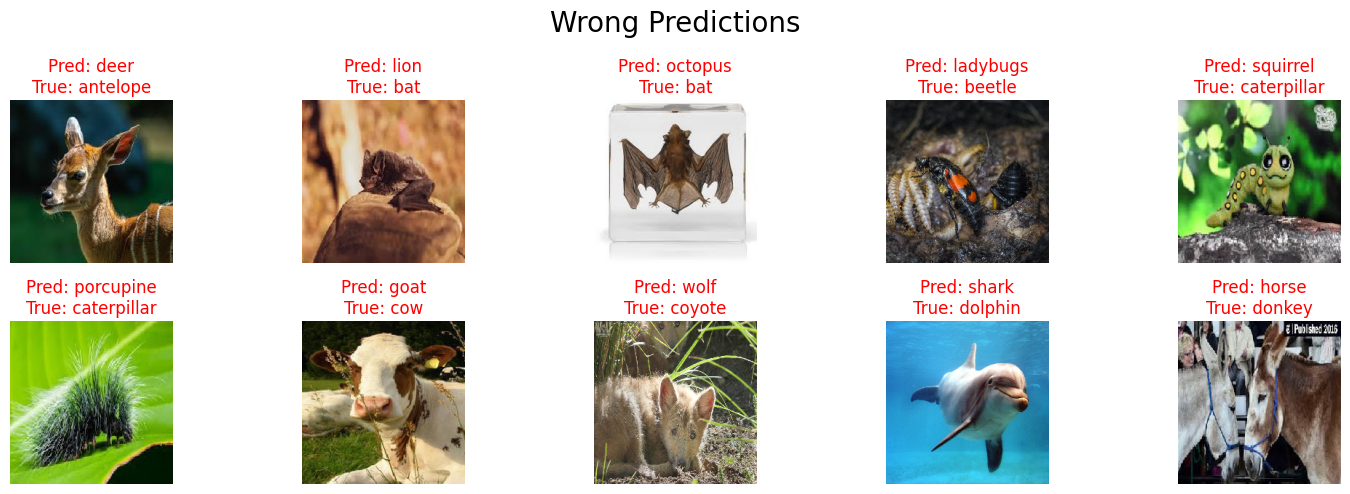


-------------------------------------------------

**Save Predictions for EfficientNetB3.**


-------------------------------------------------
-------------------------------------------------




3 resnet ResNet50

3.3. MODEL 1 - ResNet50


3.3.0. LOAD DATASETS 
 PERFORM IMAGE AUGMENTATIONS ON TRAINING SET.**

Performing data augmentations for resnet model

Found 3780 images belonging to 90 classes.
Found 810 images belonging to 90 classes.
Found 810 images belonging to 90 classes.

-------------------------------------------------

3.3.1. BUILD / TRAIN ResNet50 MODEL.



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.1894 - loss: 3.8677
Epoch 1: val_loss improved from inf to 1.25729, saving model to ./cis730_term_project/checkpoints/ResNet50CheckPoint_data_augment.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 87s 635ms/step - accuracy: 0.1910 - loss: 3.8591 - val_accuracy: 0.7346 - val_loss: 1.2573
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.8020 - loss: 1.0050
Epoch 2: val_loss improved from 1.25729 to 0.74346, saving model to ./cis730_term_project/checkpoints/ResNet50CheckPoint_data_augment.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 67s 562ms/step - accuracy: 0.8021 - loss: 1.0041 - val_accuracy: 0.8370 - val_loss: 0.7435
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.8988 - loss: 0.5446
Epoch 3: val_loss improved from 0.74346 to 0.58633, saving model to ./cis730_term_project/checkpoints/ResNet50CheckPoint_data_augment.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 66s 558ms/step - accuracy: 0.8988 - loss: 0.5444 - 

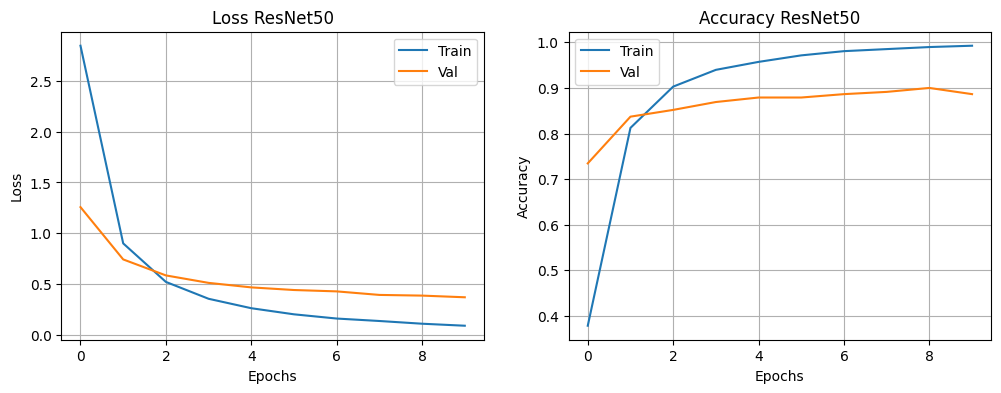


-------------------------------------------------

3.3.2. FINE TUNE ResNet50 MODEL.



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ resnet50 (Functional)       │ (None, 7, 7, 2048)    │ 23,587,712 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_5  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_5 (Dense)             │ (None, 90)            │    184,410 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 24,140,944 (92.09 MB)

 Trainable params: 184,410 (720.35 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 368,822 (1.41 MB)


-------------------------------------------------

Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.9929 - loss: 0.0810
Epoch 1: val_loss did not improve from 0.37157
119/119 ━━━━━━━━━━━━━━━━━━━━ 83s 621ms/step - accuracy: 0.9929 - loss: 0.0810 - val_accuracy: 0.8938 - val_loss: 0.3797
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.9931 - loss: 0.0736
Epoch 2: val_loss improved from 0.37157 to 0.36632, saving model to ./cis730_term_project/checkpoints/ResNet50CheckPoint_data_augment.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 74s 625ms/step - accuracy: 0.9931 - loss: 0.0736 - val_accuracy: 0.8926 - val_loss: 0.3663
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.9946 - loss: 0.0633
Epoch 3: val_loss did not improve from 0.36632
119/119 ━━━━━━━━━━━━━━━━━━━━ 68s 574ms/step - accuracy: 0.9947 - loss: 0.0633 - val_accuracy: 0.8975 - val_loss: 0.3742
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.9972 - loss: 0.0525
Ep

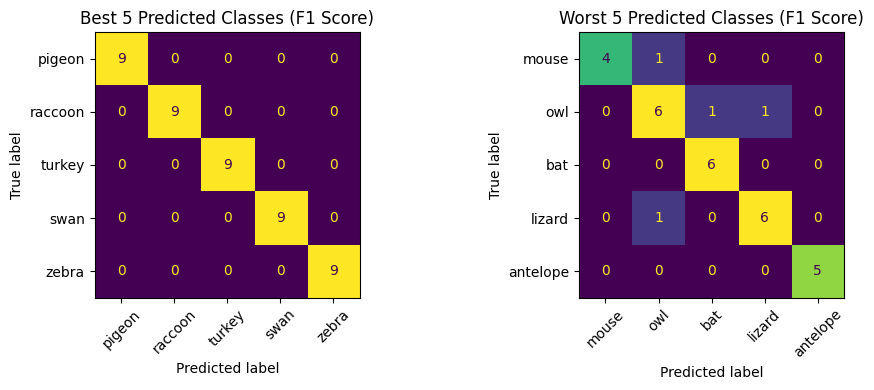


-------------------------------------------------

**Wrong predictions for ResNet50.**

Found 84 misclassified images.

-------------------------------------------------



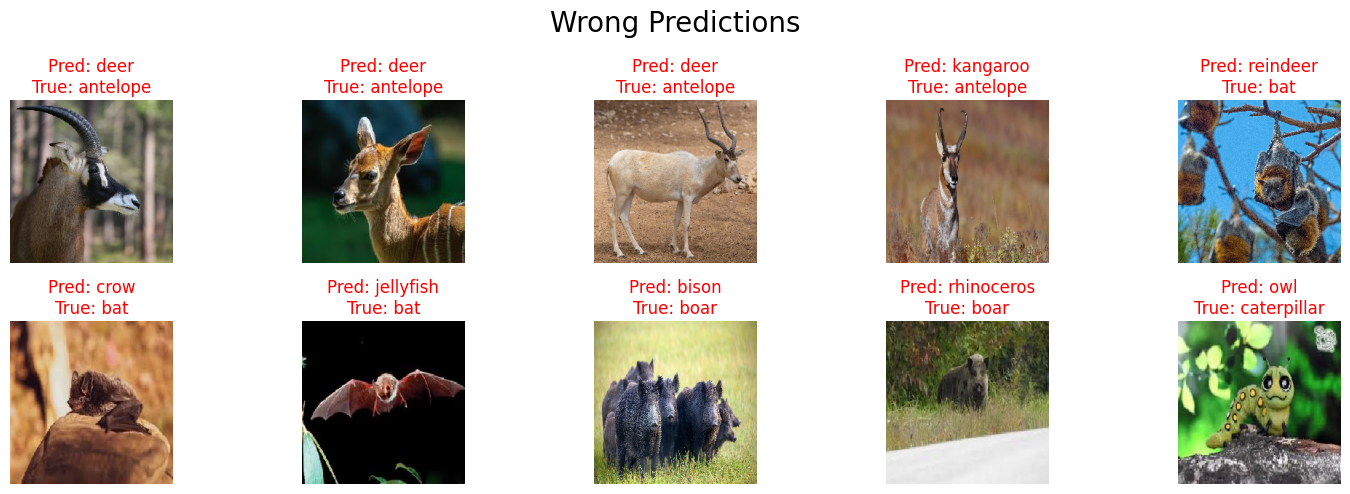


-------------------------------------------------

**Save Predictions for ResNet50.**


-------------------------------------------------
-------------------------------------------------






In [41]:
model_names = {
    "mobilenet": "MobileNetV2",
    "efficientnet": "EfficientNetB3",
    "resnet": "ResNet50"
}

for index, (model_name, keras_model) in enumerate(model_names.items()):
    print(index+1, model_name, keras_model)
    run_augmentation_processes(
        model_name=model_name,
        keras_model=keras_model,
        index=index
    )